Import Libraries

In [1]:
# default libs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Forcesting libs
from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters

# default lib for ignore warinigs
import warnings
warnings.filterwarnings('ignore')

# default params for all schemas
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

Load the data

In [2]:
# read the dataset
df = pd.read_csv('PETR4.SA.csv', index_col= ['Date'], parse_dates=['Date'])
# drop the useless columns
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
# drop all NaN values
df = df.dropna()

Visualizar se a série é estacionária

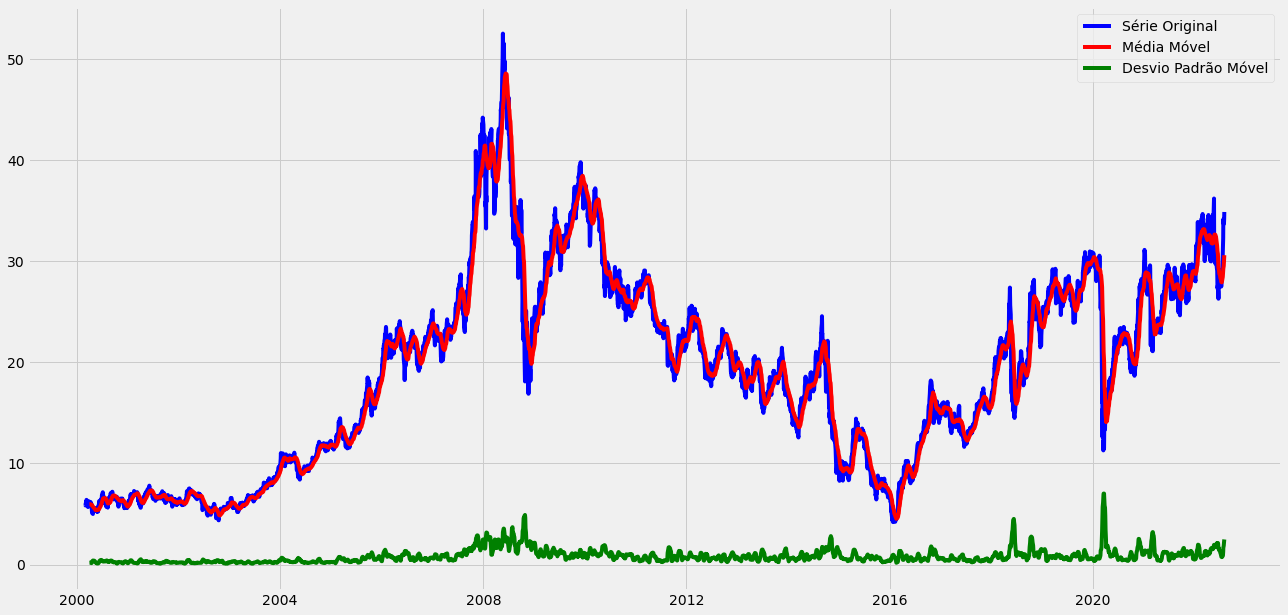

In [3]:
# Visualise if the data is stationary or not
rolling_mean = df.rolling(window = 22).mean()
rolling_std = df.rolling(window = 22).std()

# ploting the data
plt.plot(df, color = 'blue', label = 'Série Original')
plt.plot(rolling_mean, color = 'red', label = 'Média Móvel')
plt.plot(rolling_std, color = 'green', label = 'Desvio Padrão Móvel')
plt.legend(loc = 'best')
#plt.title('Rolling Mean || Rolling Standard Deviation')
plt.show()

Teste ADF

In [4]:
# getting the result of:
# >> ADF Statistic
# >> P-Values
# >> Critical Values
result = adfuller(df['Close'])
print('ADF Statistic: {}'.format(result[0]))
print('P-Values: {}'.format(result[1]))

print('Critical Values: ')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -2.1921213878232764
P-Values: 0.20911735539422166
Critical Values: 
	1%: -3.431517642053415
	5%: -2.862055983748354
	10%: -2.5670446566729552


Sendo não escionária, tiraremos o log

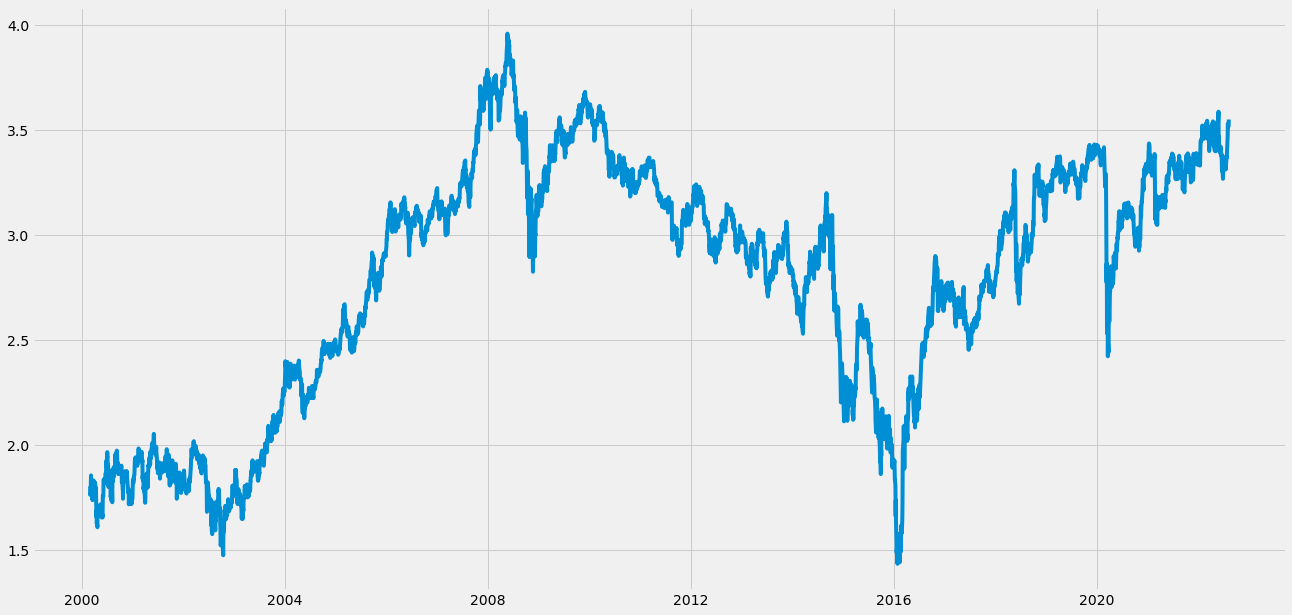

In [5]:
# Taking the log of the data
df_log = np.log(df)
plt.plot(df_log)

In [34]:
# function to stabilize data
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=22).mean()
    rolling_std = timeseries.rolling(window=22).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Média Móvel')
    std = plt.plot(rolling_std, color='green', label='Desvio Padrão Móvel')
    plt.legend(loc='best')
    #plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Close'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

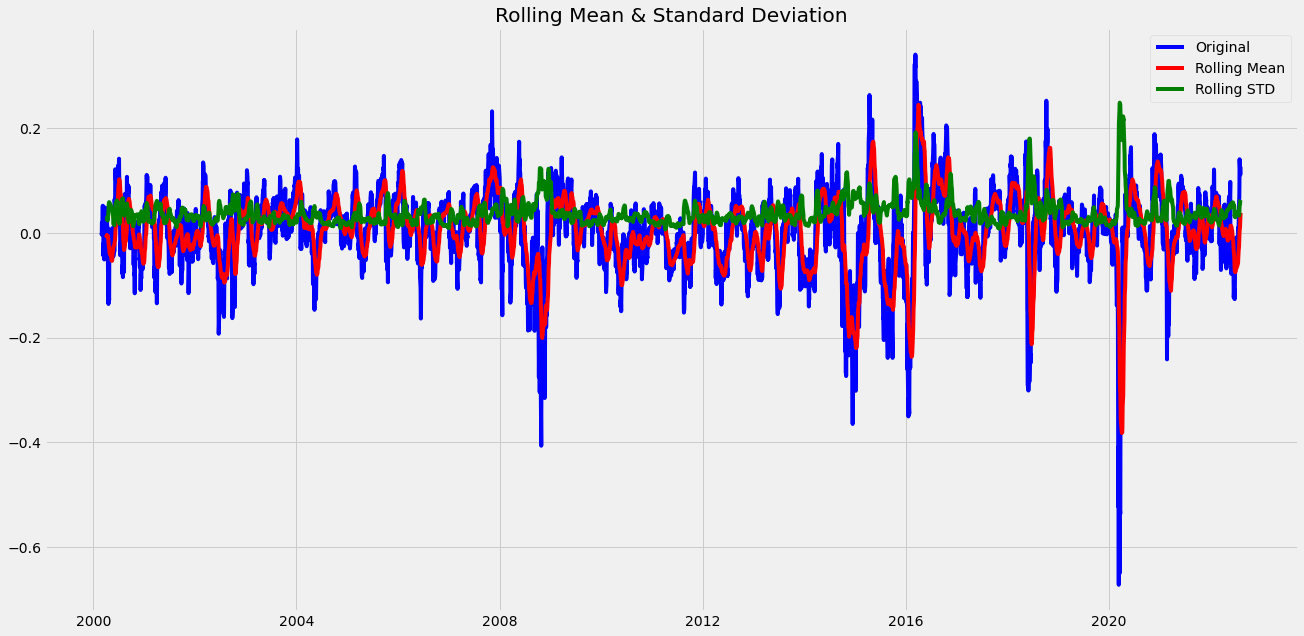

ADF Statistic: -11.817341892219563
p value: 8.575714078162628e-22
Critical Values:
	1%: -3.431512452930857
	5%: -2.862053691111228
	10%: -2.567043436231625


In [7]:
# Exponential decay method
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

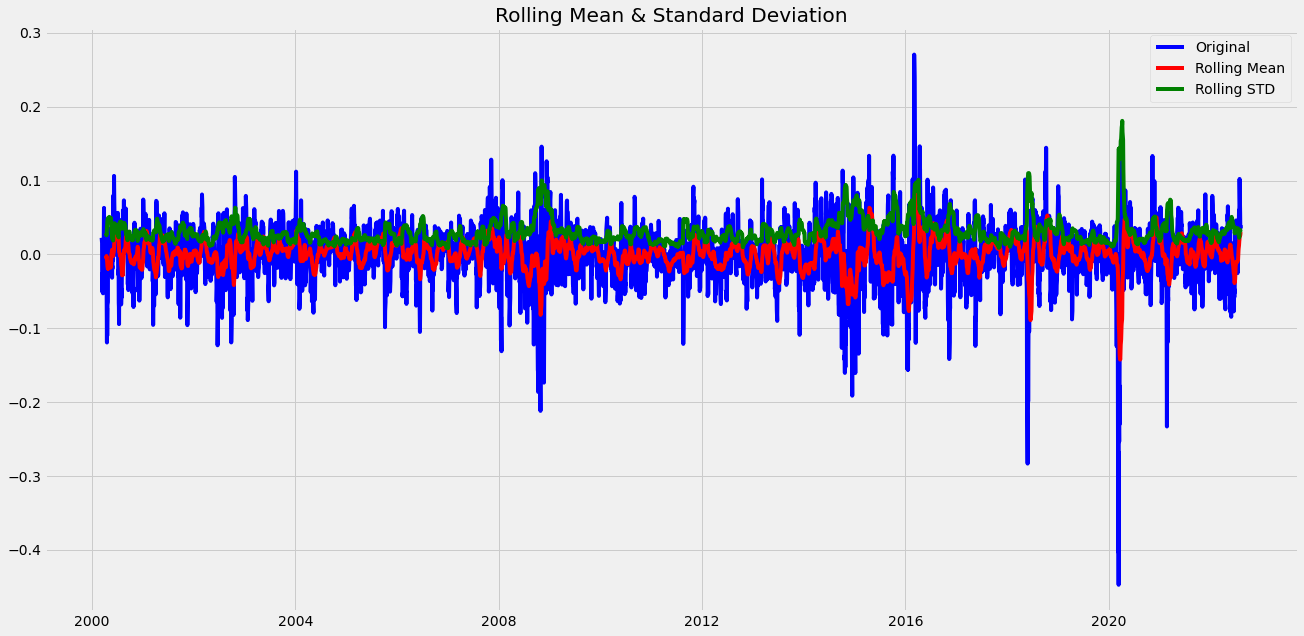

ADF Statistic: -19.24450922423449
p value: 0.0
Critical Values:
	1%: -3.431514523035383
	5%: -2.8620546057169105
	10%: -2.5670439231043076


In [8]:
# Subtracting the rolling mean
rolling_mean = df_log.rolling(window=8).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

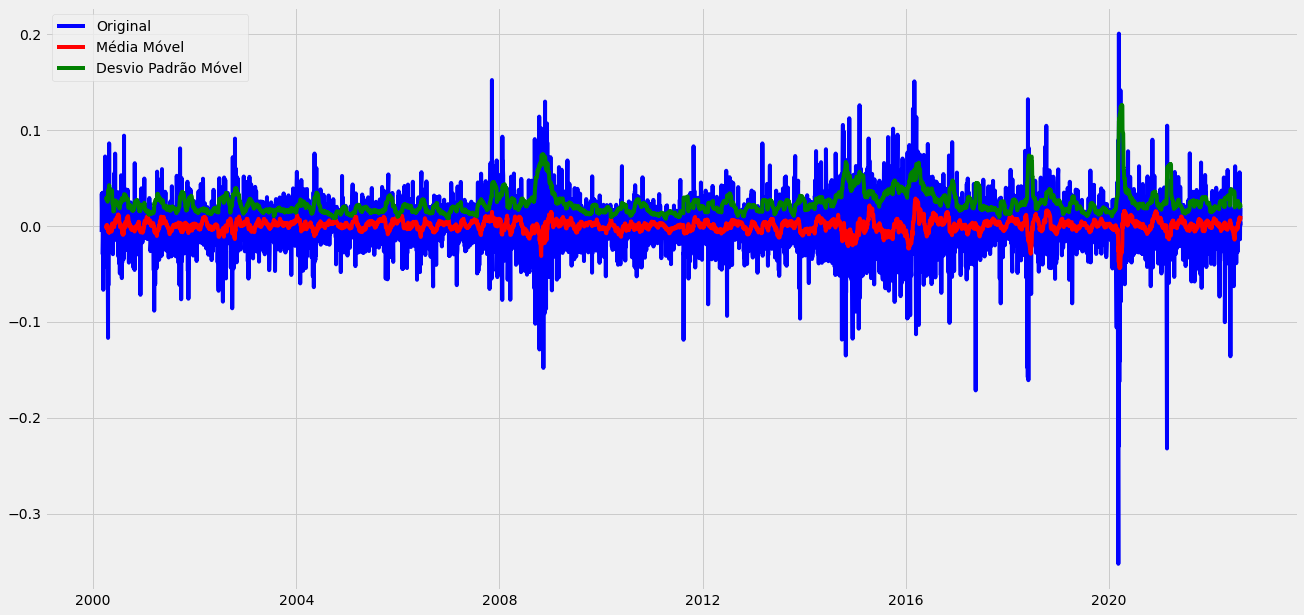

ADF Statistic: -27.390559152486542
p value: 0.0
Critical Values:
	1%: -3.431512452930857
	5%: -2.862053691111228
	10%: -2.567043436231625


In [35]:
# The time sifting
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

Finalmente, o ARIMA

In [10]:
from statsmodels.tsa.arima.model import ARIMA

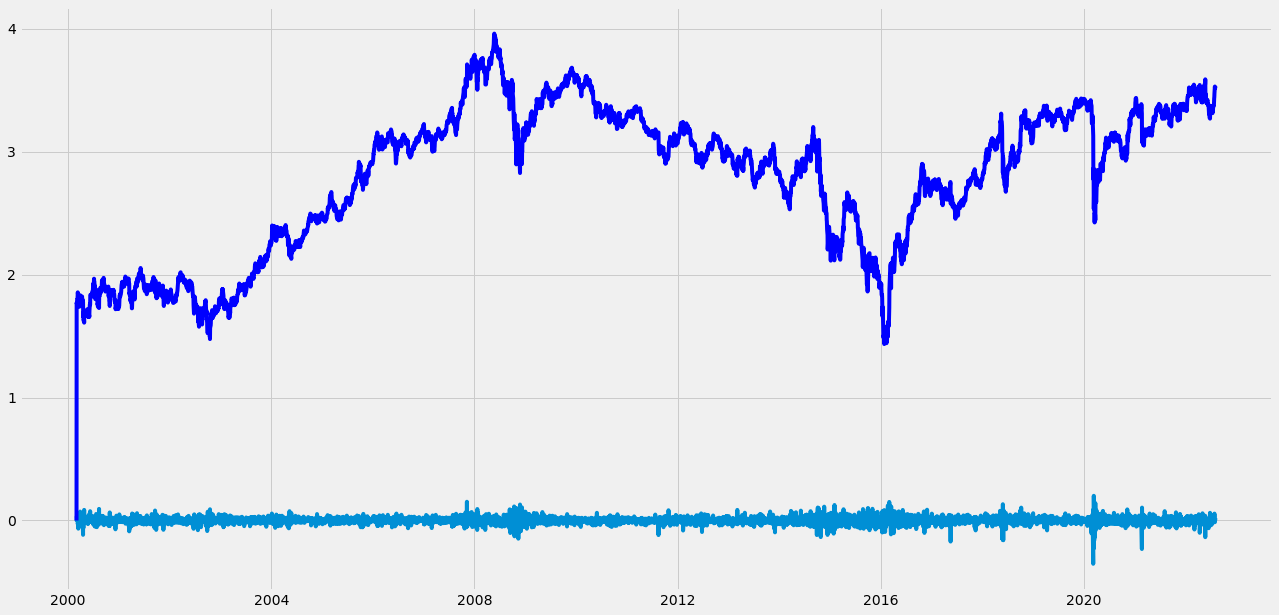

In [11]:
# ARIMA model
#decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='blue')

In [12]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 5636
Model:                 ARIMA(2, 1, 2)   Log Likelihood               12341.114
Date:                Mon, 08 Aug 2022   AIC                         -24672.227
Time:                        20:12:38   BIC                         -24639.044
Sample:                             0   HQIC                        -24660.667
                               - 5636                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1428      2.010     -0.071      0.943      -4.082       3.797
ar.L2         -0.5182      1.279     -0.405      0.685      -3.024       1.988
ma.L1          0.1390      2.013      0.069      0.945      -3.807       4.085
ma.L2          0.5164      1.283      0.402      0.687      -1.998       3.031
sigma2         0.0007    5.6e-06    130.862      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       59.33   Jarque-Bera (JB):             28830.93
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               2.53   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

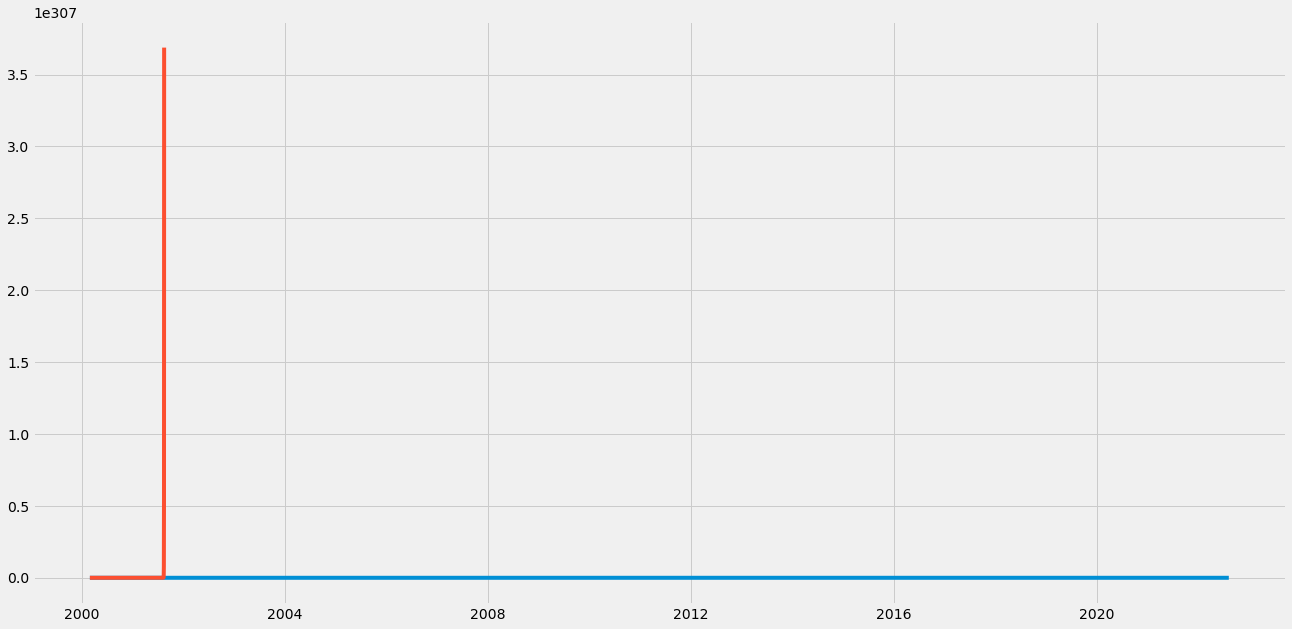

In [13]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['Close'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

In [14]:
serie_predicao = np.exp(results.predict(end=8556))

In [15]:
datetime = pd.date_range('03-01-2000', periods=8557, freq='B')

In [16]:
datetime

DatetimeIndex(['2000-03-01', '2000-03-02', '2000-03-03', '2000-03-06',
               '2000-03-07', '2000-03-08', '2000-03-09', '2000-03-10',
               '2000-03-13', '2000-03-14',
               ...
               '2032-12-03', '2032-12-06', '2032-12-07', '2032-12-08',
               '2032-12-09', '2032-12-10', '2032-12-13', '2032-12-14',
               '2032-12-15', '2032-12-16'],
              dtype='datetime64[ns]', length=8557, freq='B')

In [17]:
serie_predicao.index = datetime

In [18]:
serie_predicao = pd.DataFrame(serie_predicao)

In [19]:
serie_predicao.columns = ['previsao']

In [20]:
serie_predicao.columns

Index(['previsao'], dtype='object')

In [21]:
serie_predicao.set_index(serie_predicao.index, inplace=True)

In [22]:
df

,Close
Date,
2000-03-01,5.875000
2000-03-02,5.838000
2000-03-03,6.038000
2000-03-06,6.038000
2000-03-07,6.038000
...,...
2022-08-01,33.680000
2022-08-02,33.830002
2022-08-03,33.849998


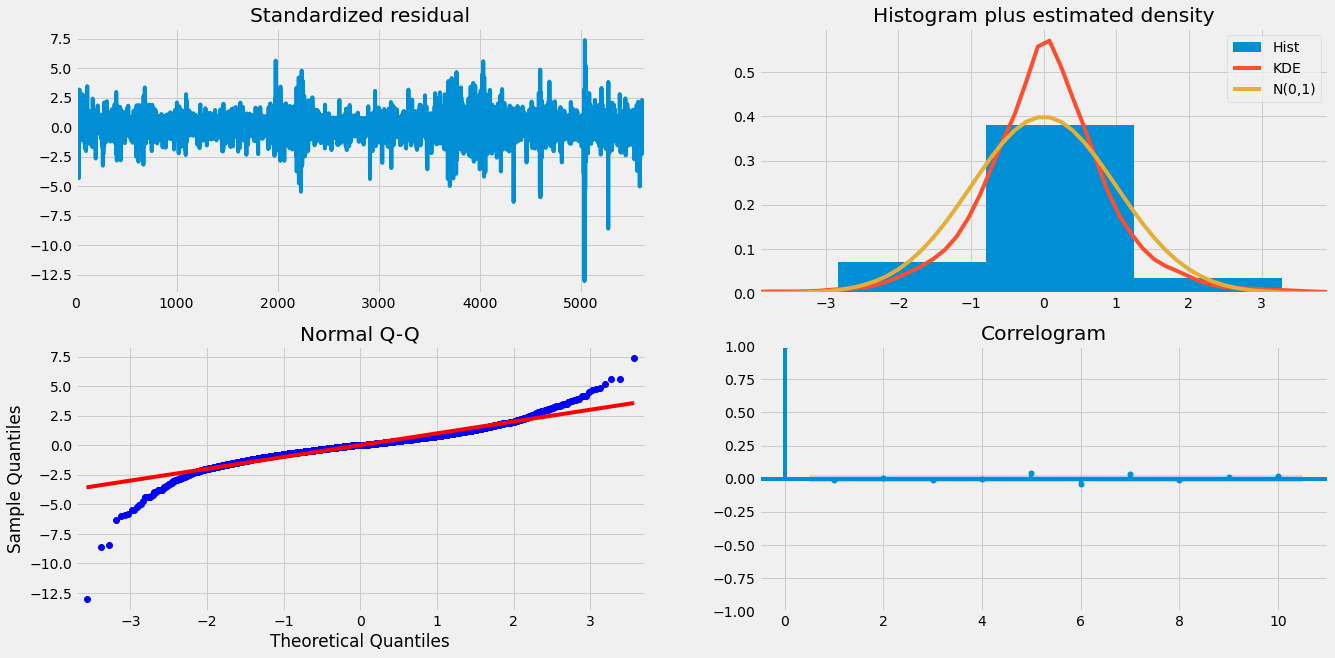

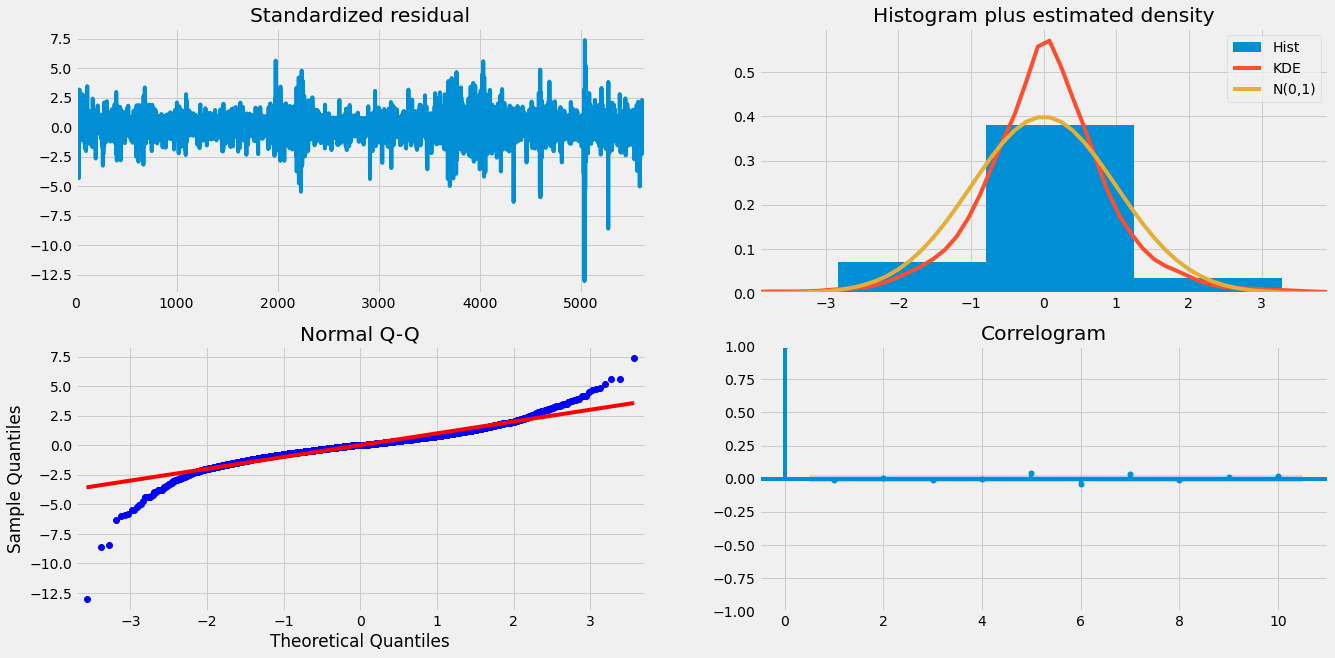

In [23]:
results.plot_diagnostics()

Text(0, 0.5, 'Valor (R$)')

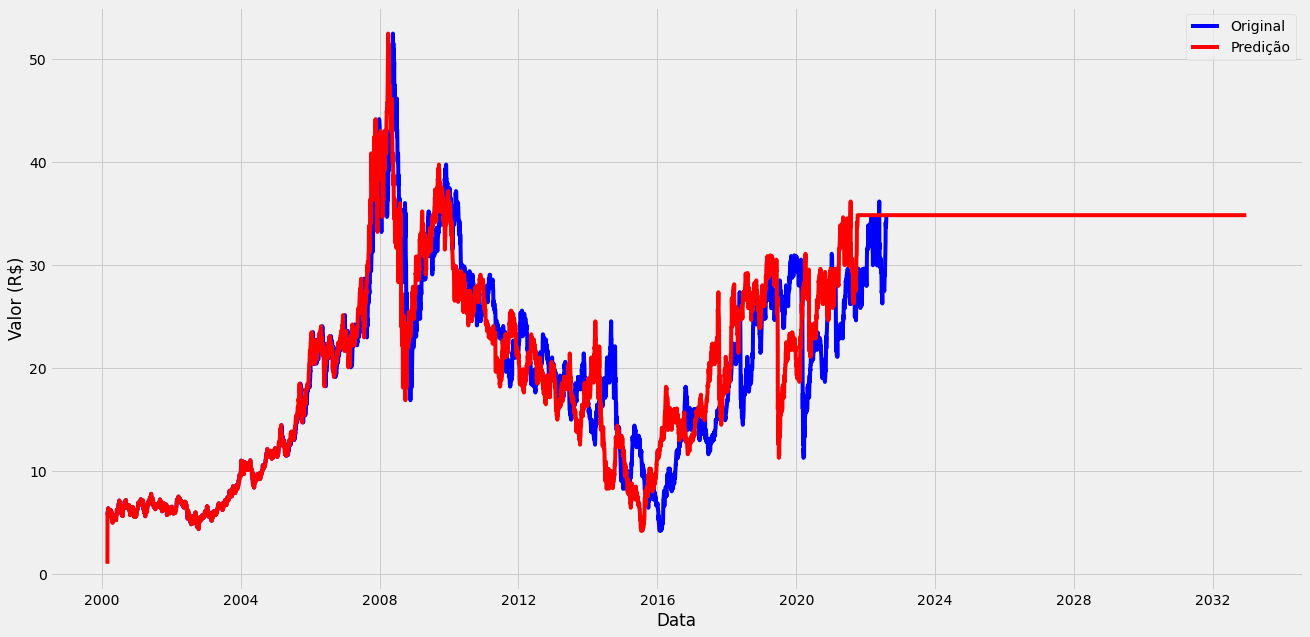

In [24]:
#plot two series
plt.plot(df, color='blue', label='Original')
plt.plot(serie_predicao, color='red', label='Predição')
plt.legend(loc='best')
plt.xlabel('Data')
plt.ylabel('Valor (R$)')

In [25]:
np.exp(3.551610) #Valor que deverá ser feito o CAPM

34.86941207278124

Teste de Chow

In [26]:
#sem jeito =(

CAPM

In [27]:
import numpy as np
import pandas_datareader as pdr
import datetime as dt
import pandas as pd
 
tickers = ['PETR4.SA', '^BVSP']
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2022, 7, 8)
 
data = pdr.get_data_yahoo(tickers, start, end, interval="m")
 
data = data['Adj Close']
 
log_returns = np.log(data/data.shift())

In [28]:
data

Symbols,PETR4.SA,^BVSP
Date,,
2000-01-01,NaN,16388.0
2000-02-01,2.582828,17660.0
2000-03-01,2.638732,17820.0
2000-04-01,2.404377,15538.0
2000-05-01,2.342657,14957.0
...,...,...
2022-03-01,27.437729,119999.0
2022-04-01,24.837502,107876.0
2022-05-01,26.974707,111351.0


In [57]:
cov = log_returns.cov()
var = log_returns['^BVSP'].var()
 
beta = cov.loc['PETR4.SA', '^BVSP']/var
 
risk_free_return = 0.02
market_return = 0.08
expected_return = risk_free_return + beta*(market_return - risk_free_return)

In [58]:
beta

1.2650120814059902

In [59]:
expected_return

0.09590072488435941